In [1]:
%config InlineBackend.figure_formats = ['retina']

In [119]:
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from seaborn import heatmap 
from keras import optimizers
from keras.layers import Dense, Activation
from keras.models import Sequential

# Import data

In [3]:
data = pd.read_csv('./data/SeoulBikeData.csv', encoding='latin1')

In [4]:
data.Date = pd.to_datetime(data.Date, dayfirst=True)

# Change string values to integers

In [5]:
data['Functioning Day'] = (data['Functioning Day']=='Yes').astype(int)

In [6]:
data['Holiday'] = (data['Holiday']=='Holiday').astype(int)

In [7]:
data = data.replace({'Seasons': {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}})

In [8]:
data = data.set_index(data.Date).drop('Date', axis=1)

In [9]:
data

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
Date,,,,,,,,,,,,,
2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,3,0,1
2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,3,0,1
2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,3,0,1


In [10]:
data.corr('pearson')

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
Rented Bike Count,1.000000,4.102573e-01,0.538558,-0.199780,0.121108,0.199280,0.379788,0.261837,-0.123074,-0.141804,3.596867e-01,-7.233757e-02,0.203943
Hour,0.410257,1.000000e+00,0.124114,-0.241644,0.285197,0.098753,0.003054,0.145131,0.008715,-0.021516,2.544659e-15,-1.391486e-16,0.005439
Temperature(°C),0.538558,1.241145e-01,1.000000,0.159371,-0.036252,0.034794,0.912798,0.353505,0.050282,-0.218405,5.915453e-01,-5.593084e-02,-0.050170
Humidity(%),-0.199780,-2.416438e-01,0.159371,1.000000,-0.336683,-0.543090,0.536894,-0.461919,0.236397,0.108183,1.892379e-01,-5.027765e-02,-0.020800
Wind speed (m/s),0.121108,2.851967e-01,-0.036252,-0.336683,1.000000,0.171507,-0.176486,0.332274,-0.019674,-0.003554,-1.668339e-01,2.301677e-02,0.005037
Visibility (10m),0.199280,9.875348e-02,0.034794,-0.543090,0.171507,1.000000,-0.176630,0.149738,-0.167629,-0.121695,1.119742e-01,3.177281e-02,-0.026000
Dew point temperature(°C),0.379788,3.054372e-03,0.912798,0.536894,-0.176486,-0.176630,1.000000,0.094381,0.125597,-0.150887,5.824180e-01,-6.675910e-02,-0.052837
Solar Radiation (MJ/m2),0.261837,1.451309e-01,0.353505,-0.461919,0.332274,0.149738,0.094381,1.000000,-0.074290,-0.072301,9.468096e-02,-5.077255e-03,-0.007665
Rainfall(mm),-0.123074,8.714642e-03,0.050282,0.236397,-0.019674,-0.167629,0.125597,-0.074290,1.000000,0.008500,3.345293e-02,-1.426911e-02,0.002055
Snowfall (cm),-0.141804,-2.151645e-02,-0.218405,0.108183,-0.003554,-0.121695,-0.150887,-0.072301,0.008500,1.000000,-1.454573e-01,-1.259072e-02,0.032089


> Il serait peut être pertinent certaines features si celles ci sont très corrélées avec des features déjà présentes, par exemple :
>>  Dew point temperature & Temperature 

Intérêt d'enlever certaines features très corrélées : 
- interpretabilité 
- rapidité du modèle 

In [13]:
X, y = data.drop('Rented Bike Count', axis=1), data['Rented Bike Count']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [44]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Liste utilisée pour comparer les performances des méthodes 
performance_list = []

# SVR

In [45]:
regr = SVR(C=100)
regr.fit(x_train, y_train)

SVR(C=100)

In [46]:
regr.score(x_train, y_train), regr.score(x_test, y_test)
performance_list.append(['SVR', regr.score(x_train, y_train), regr.score(x_test, y_test)])

In [44]:
y_pred_svr = regr.predict(x_test)

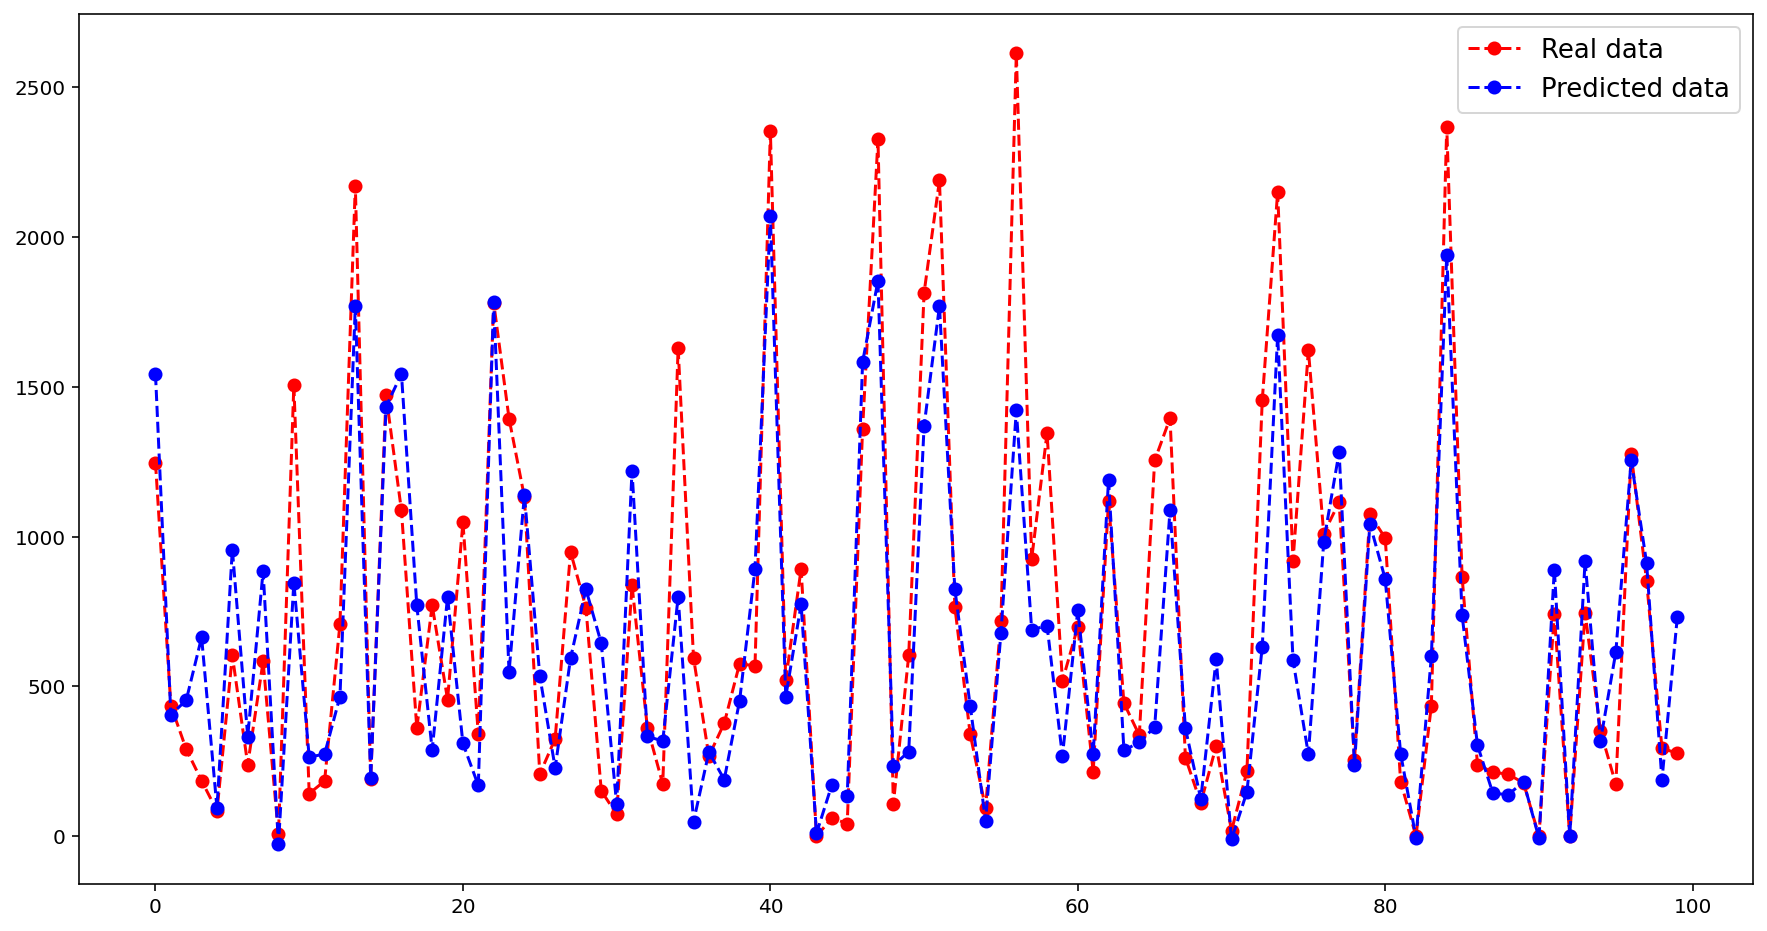

In [45]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label = 'Real data')
plt.plot(y_pred_svr[100:200], color = 'b', marker='o', linestyle='--', label = 'Predicted data')
plt.legend(fontsize=13)
plt.show()

# Lasso

In [48]:
lasso = Lasso(alpha=0.1, max_iter=5000)
lasso.fit(x_train, y_train)

Lasso(alpha=0.1, max_iter=5000)

In [49]:
lasso.score(x_train, y_train), lasso.score(x_test, y_test)
performance_list.append(['Lasso', lasso.score(x_train, y_train), lasso.score(x_test, y_test)])

In [50]:
y_pred_lasso = lasso.predict(x_test)

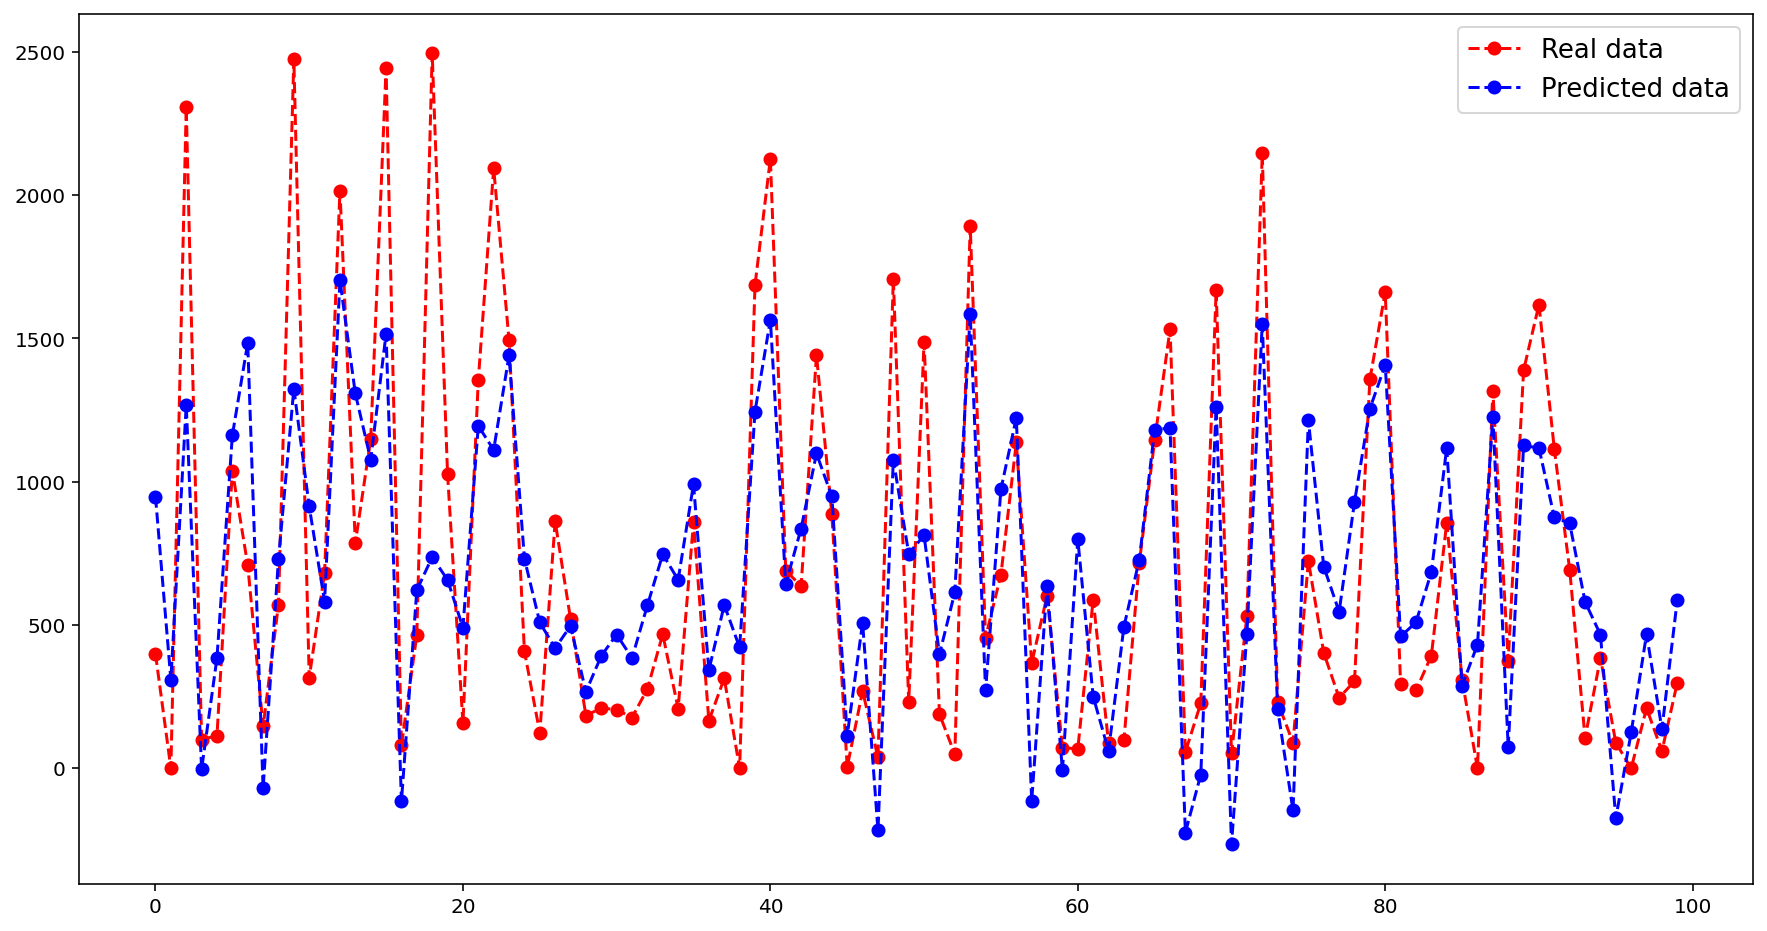

In [51]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label = 'Real data')
plt.plot(y_pred_lasso[100:200], color = 'b', marker='o', linestyle='--', label = 'Predicted data')
plt.legend(fontsize=13)
plt.show()

# Ridge

In [52]:
ridge = Ridge()
ridge.fit(x_train, y_train)

Ridge()

In [53]:
ridge.score(x_train, y_train), ridge.score(x_test, y_test)
performance_list.append(['Ridge', ridge.score(x_train, y_train), ridge.score(x_test, y_test)])

In [54]:
y_pred_ridge = ridge.predict(x_test)

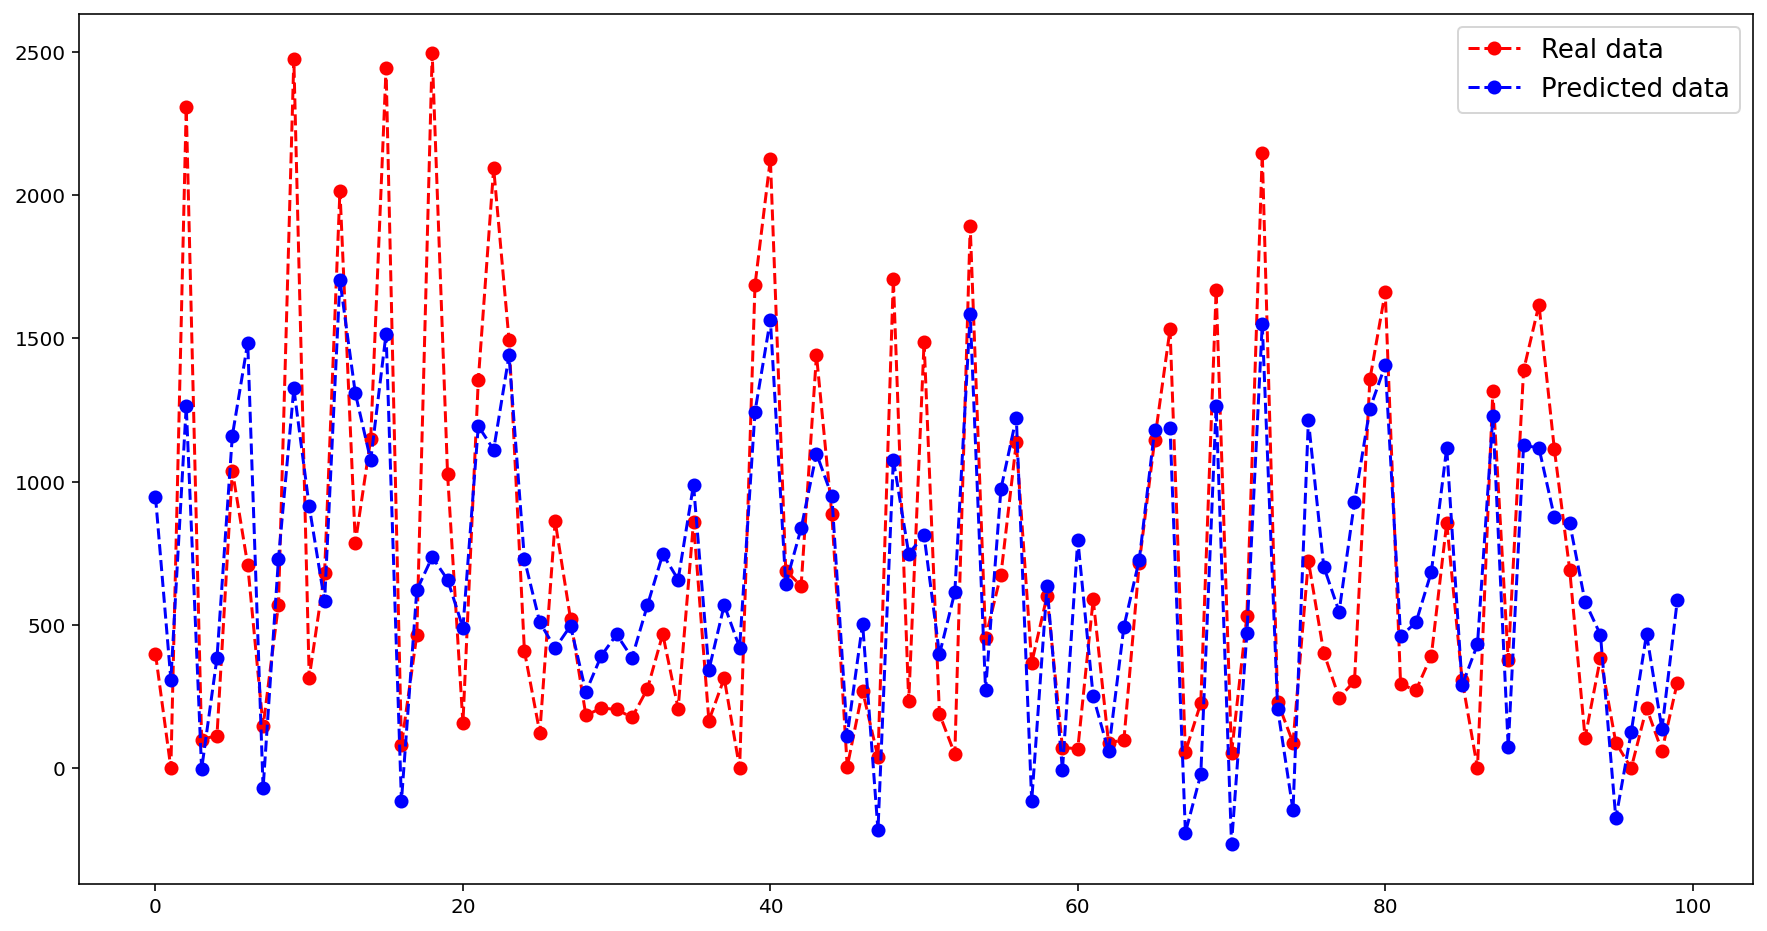

In [55]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label = 'Real data')
plt.plot(y_pred_ridge[100:200], color = 'b', marker='o', linestyle='--', label = 'Predicted data')
plt.legend(fontsize=13)
plt.show()

# Regression tree

In [115]:
reg_tree = DecisionTreeRegressor()
reg_tree.fit(x_train, y_train)

DecisionTreeRegressor()

In [116]:
reg_tree.score(x_train, y_train), reg_tree.score(x_test, y_test)
performance_list.append(['Regression Tree', reg_tree.score(x_train, y_train), reg_tree.score(x_test, y_test)])

In [117]:
y_pred_tree = reg_tree.predict(x_test)

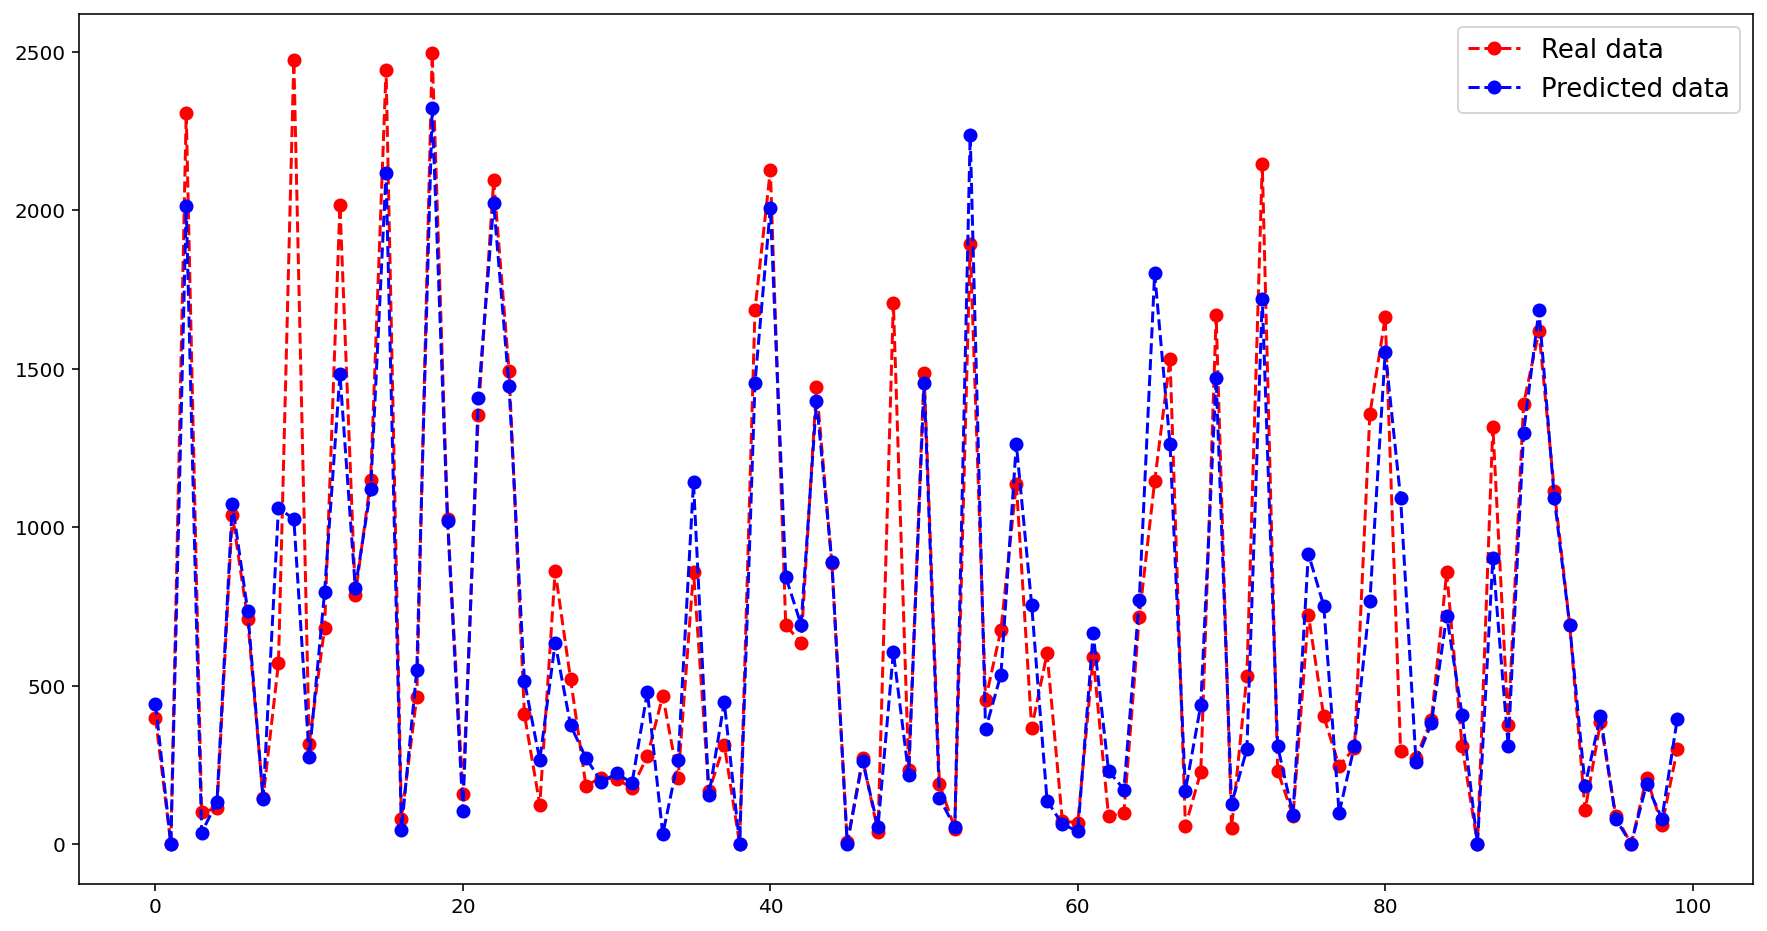

In [118]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label = 'Real data')
plt.plot(y_pred_tree[100:200], color = 'b', marker='o', linestyle='--', label = 'Predicted data')
plt.legend(fontsize=13)
plt.show()

# Random Forest regression

In [60]:
reg_forest = RandomForestRegressor()
reg_forest.fit(x_train, y_train)

RandomForestRegressor()

In [122]:
performance_list.append(['Random Forest Regressor',reg_forest.score(x_train, y_train), reg_forest.score(x_test, y_test)])
reg_forest.score(x_train, y_train), reg_forest.score(x_test, y_test)

(0.9811805331970173, 0.8781921900651694)

In [62]:
y_pred_forest = reg_forest.predict(x_test)

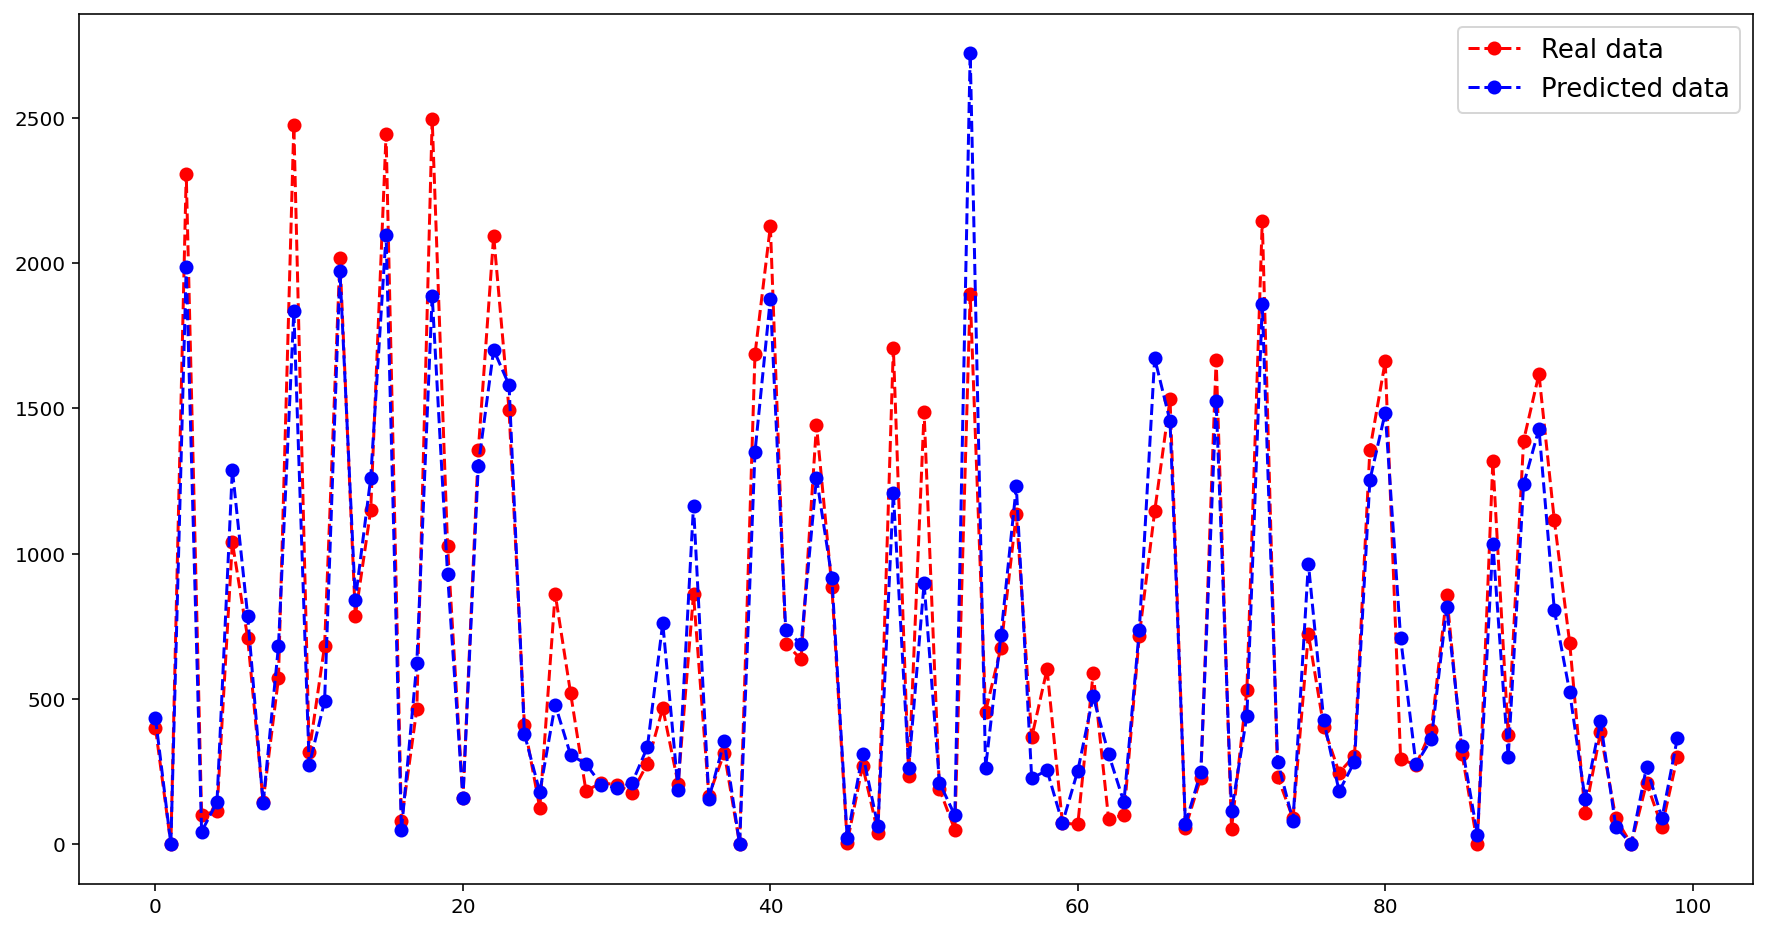

In [63]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label = 'Real data')
plt.plot(y_pred_forest[100:200], color = 'b', marker='o', linestyle='--', label = 'Predicted data')
plt.legend(fontsize=13)
plt.show()

### Cross Validation 

In [149]:
%%time 

# Test 1 
tuned_parameters = {'min_samples_leaf' : np.arange(1,10)} # Augmentation sensible du score avec ça 
param_grid = {'max_features': [2, 3],'min_samples_leaf': [1,2,3, 4, 5],'min_samples_split': [1,2,3,4]}
rf_random = GridSearchCV(RandomForestRegressor(), param_grid)

rf_random.fit(x_train, y_train)

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/huguesrb/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dis

CPU times: user 1min 33s, sys: 2.95 s, total: 1min 36s
Wall time: 1min 45s


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 3],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4]})

In [150]:
rf_random.score(x_train,y_train), rf_random.score(x_test,y_test)
rf_random.best_params_

{'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}

> On obtient un meilleur résultat sur le testing set mais un score un peu moins bon sur le training set 

In [136]:
# test 2 : 

reg_cv = cross_val_score(RandomForestRegressor(), x_train, y_train)
reg_cv

array([0.86425335, 0.86670222, 0.86969135, 0.86797615, 0.84592176])

> On obtient dans tous les cas un score qui est pire que le premier score obtenu ...

# Neural network

In [100]:
model = Sequential()

model.add(Dense(units = 128, activation='relu', input_dim=12))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1, activation='linear'))


model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [101]:
history = model.fit(x_train, y_train, batch_size = 25, epochs = 500, validation_data=(x_test, y_test), verbose=0)

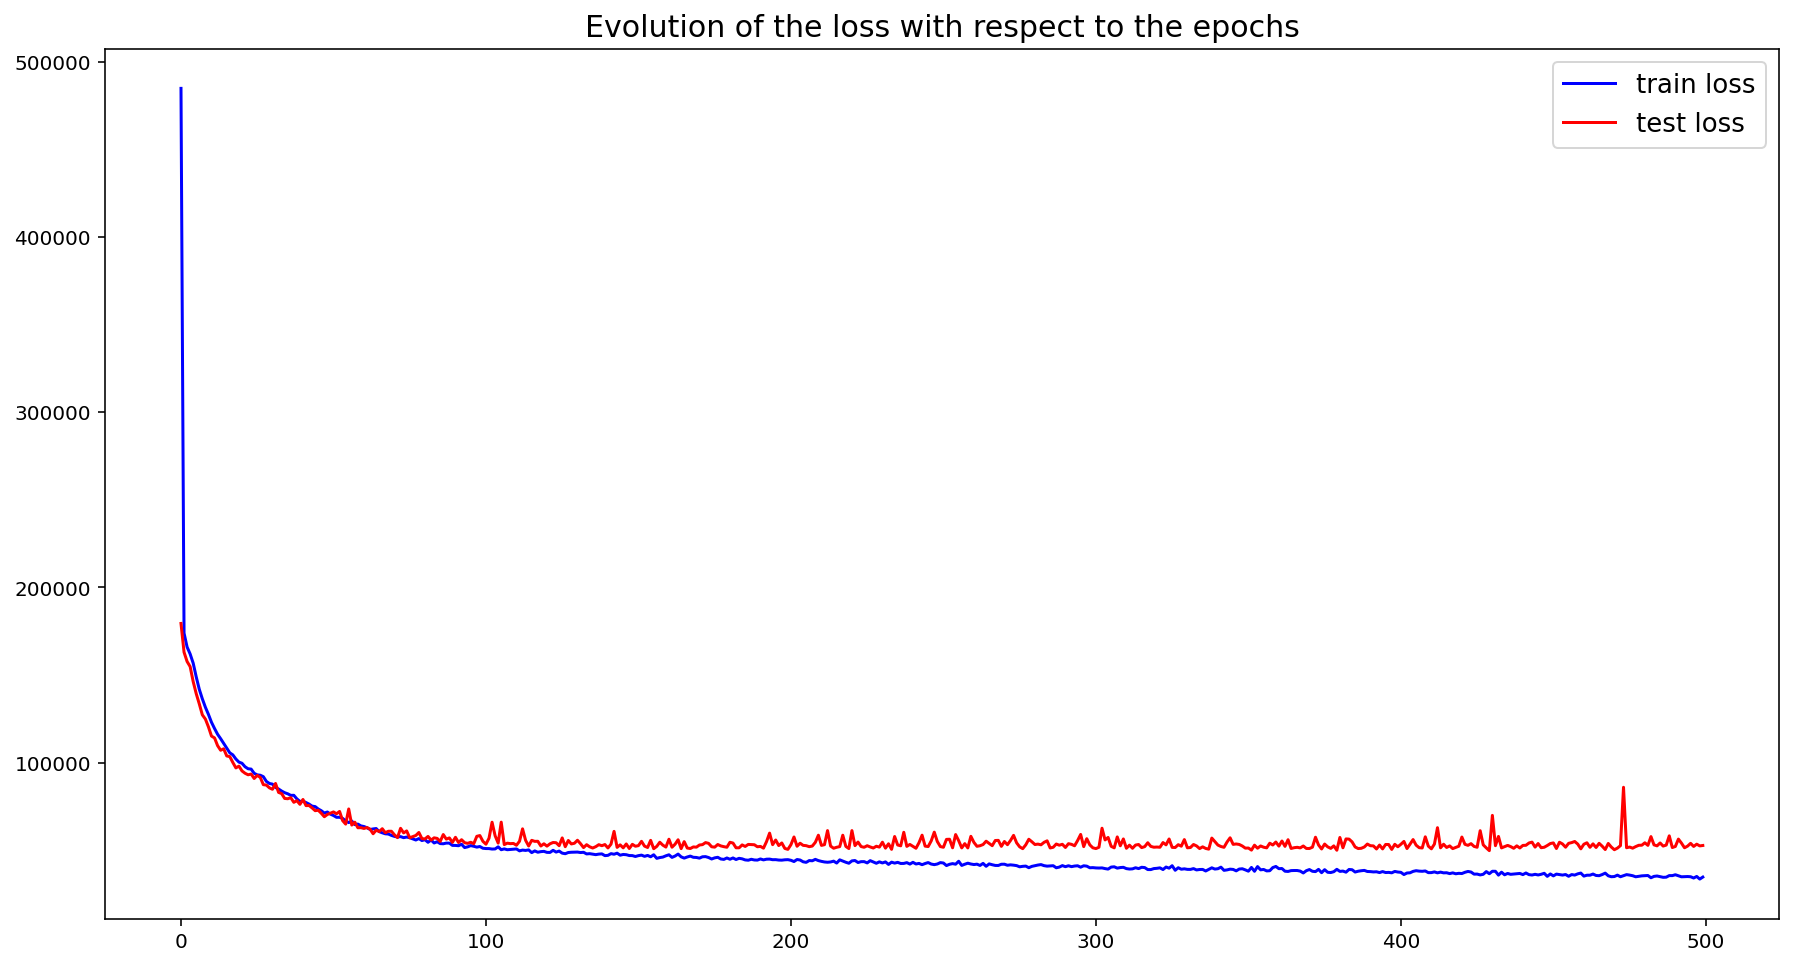

In [102]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b', label='train loss')
plt.plot(val_loss, c='r', label='test loss')
plt.title('Evolution of the loss with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()

In [108]:
y_pred_NN = model.predict(x_test)

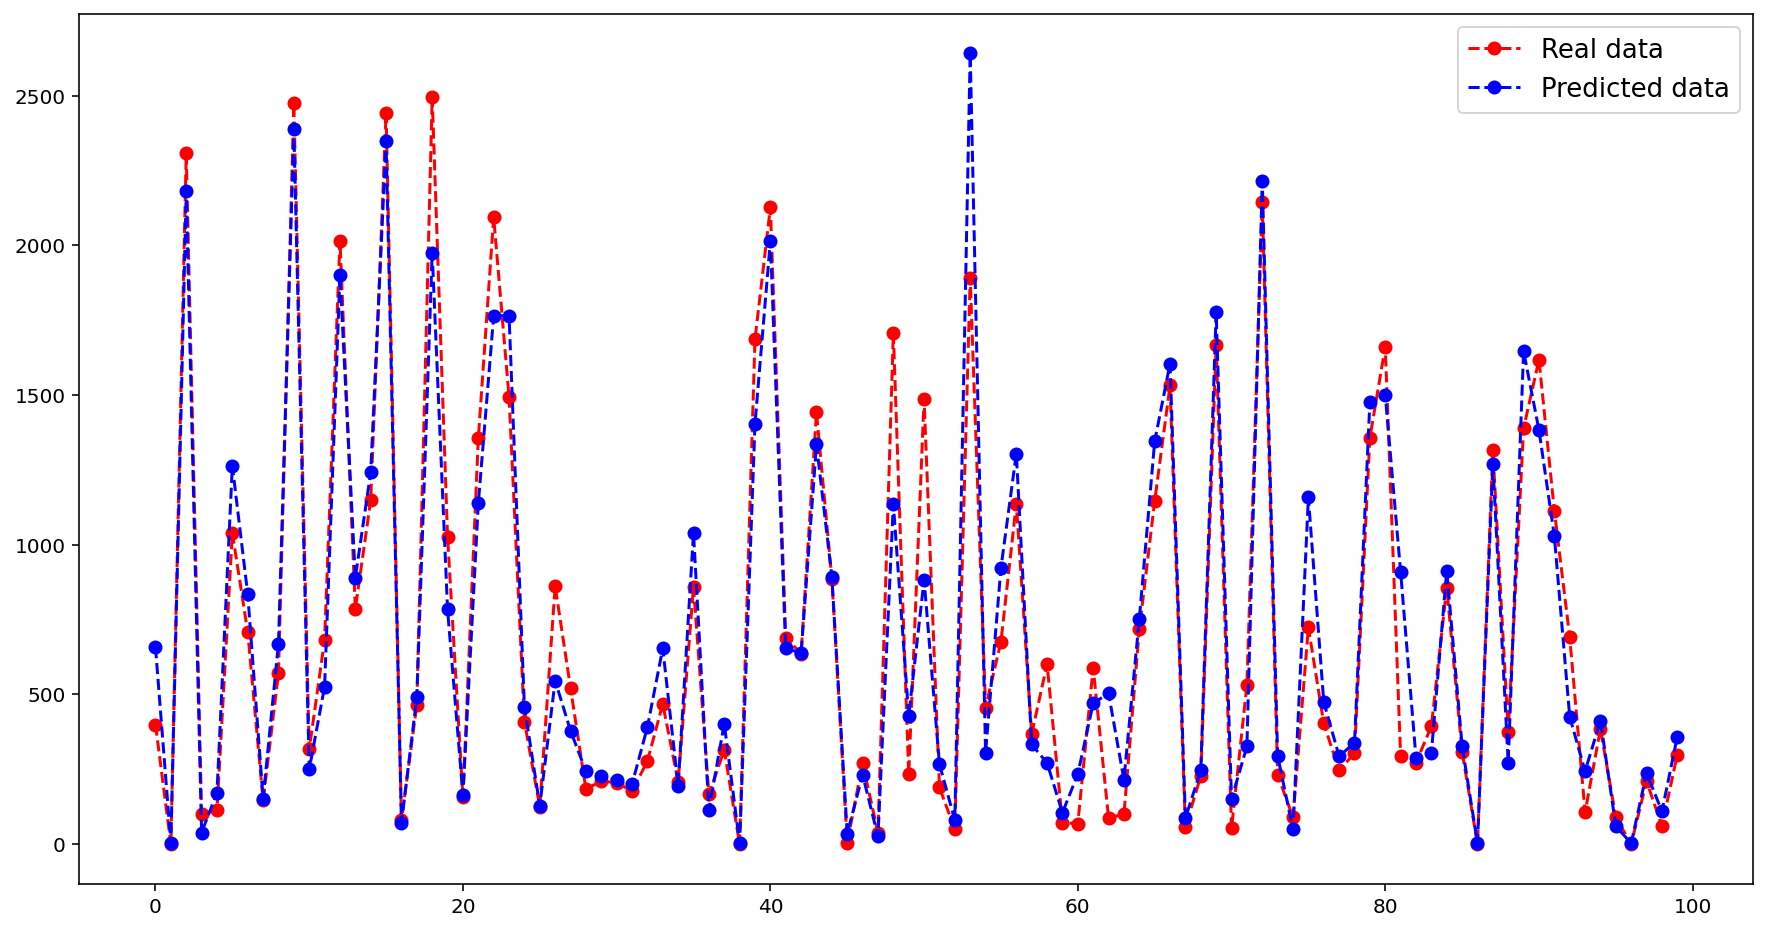

In [109]:
plt.figure(figsize=(15,8))
plt.plot(y_test.values[100:200], color = 'r', marker='o', linestyle='--', label = 'Real data')
plt.plot(y_pred_NN[100:200], color = 'b', marker='o', linestyle='--', label = 'Predicted data')
plt.legend(fontsize=13)
plt.show()

In [110]:
model.evaluate(x_test, y_test), model.evaluate(x_train, y_train)

184/184 [==============================] - 0s 1ms/step - loss: 32917.2812 - accuracy: 0.0010


([52788.2109375, 0.0], [32917.28125, 0.001022320706397295])

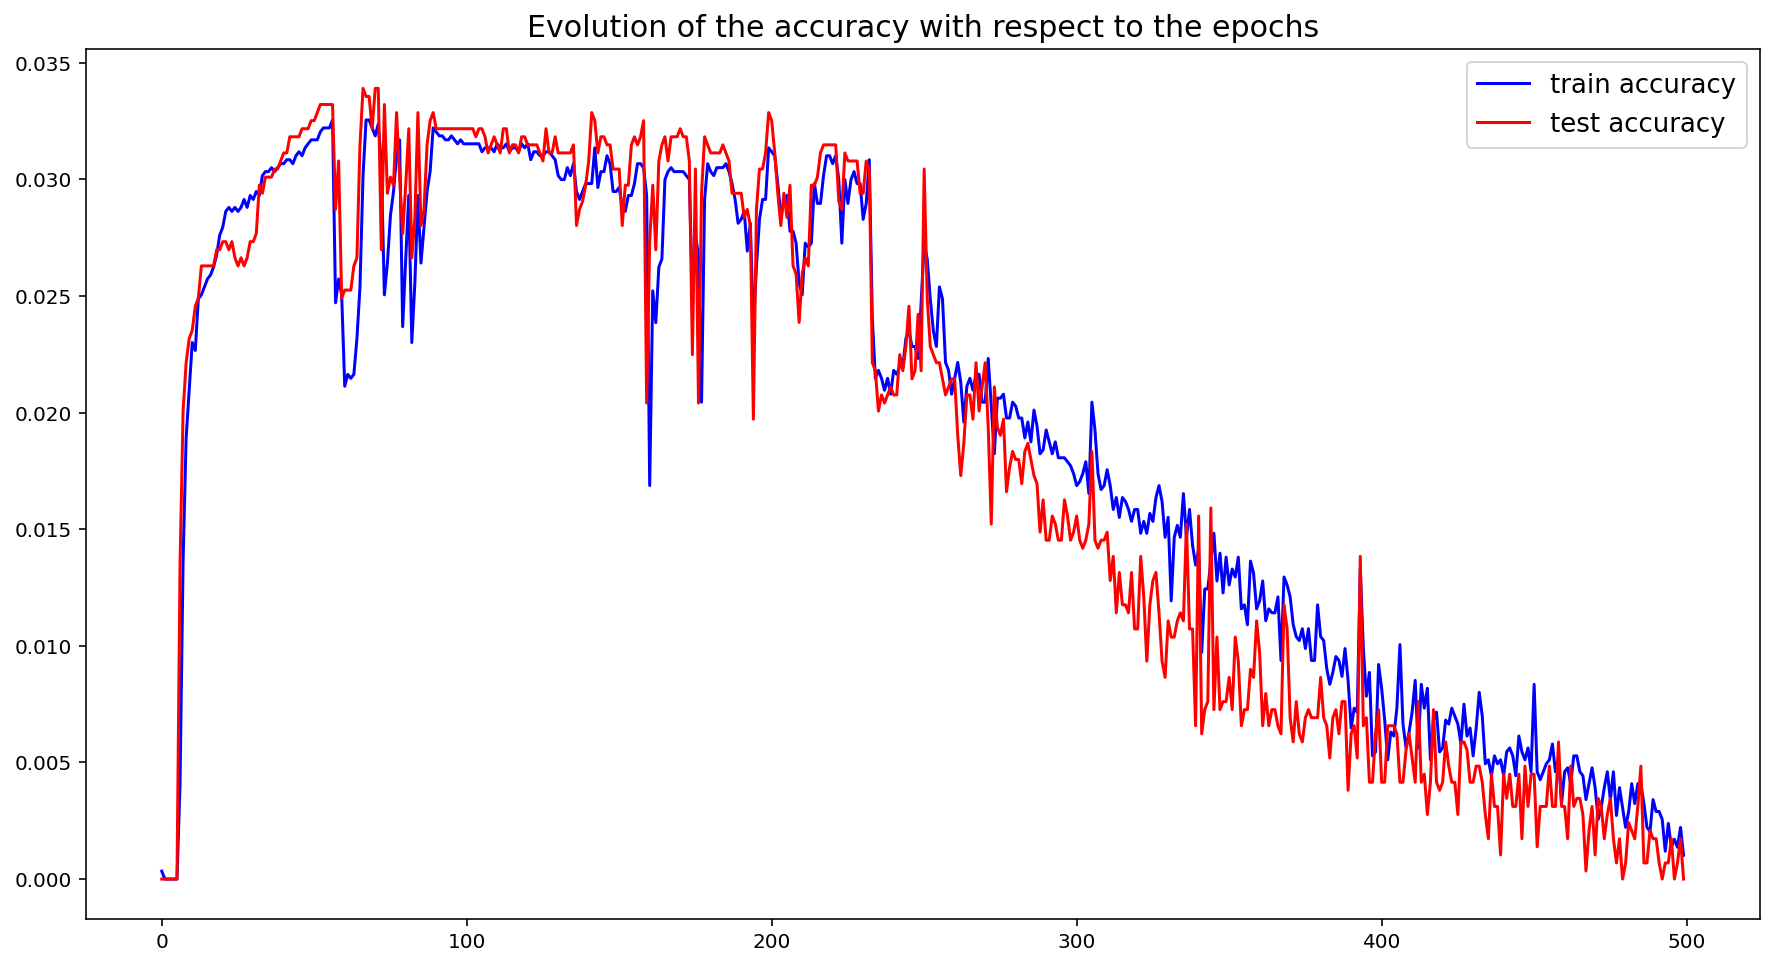

In [114]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b',label='train accuracy')
plt.plot(val_loss, c='r',label='test accuracy')
plt.title('Evolution of the accuracy with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()

- L'accuracy est vraiment très mauvaise pour le réseaux de neurones. 

### Comparaison des méthodes utilisées 

- SVR 
- Ridge
- LASSO
- Random Tree
- Random Forest Regression
- Neural Network 

In [64]:
print('Method name || Training Score || Testing score ')
for i,j,k in performance_list:
    print('{} || {} || {} '.format(i,j,k))


Method name || Training Score || Testing score 
SVR || 0.7264290212131643 || 0.7318253591992174 
Lasso || 0.5375750754477506 || 0.5576877891391984 
Ridge || 0.5375765837482678 || 0.5577117746649949 
Regression Tree || 1.0 || 0.7559463755030681 
Random Forest Regressor || 0.9811805331970173 || 0.8781921900651694 


>On peut voir que la méthode qui nous donne le meilleur résultat sur le testing set est ```RandomForestRegressor``` avec en plus une excellente performance sur le training set.

Ceci pousse à choisir le RandomForestRegressor comme methode que l'on va comparer avec le réseau de neurone.

### Analyse réseau de neurones  : 

- On a une loss qui devient très vite très faible sur les testing et training set. 